In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [5]:
# Load raw datasets from data/raw/
fraud_data = pd.read_csv('../data/raw/Fraud_data.csv')
ip_country = pd.read_csv('../data/raw/IPAddress_to_Country.csv')
creditcard_data = pd.read_csv('../data/raw/creditcard.csv')

# Display basic info
print("Fraud_data shape:", fraud_data.shape)
print("IPAddress_to_Country shape:", ip_country.shape)
print("creditcard_data shape:", creditcard_data.shape)

Fraud_data shape: (151112, 11)
IPAddress_to_Country shape: (138846, 3)
creditcard_data shape: (284807, 31)


3.Handle Missing Values

In [6]:
# Check for missing values
missing_fraud = fraud_data.isnull().sum()
print("Missing values in Fraud_data:\n", missing_fraud)

# Impute or drop missing values
fraud_data['purchase_value'].fillna(fraud_data['purchase_value'].median(), inplace=True)
fraud_data.dropna(subset=['user_id', 'ip_address'], inplace=True)

# Save interim cleaned data
fraud_data.to_csv('../data/processed/cleaned_fraud_data.csv', index=False)
print("Missing values handled. Saved to data/processed/cleaned_fraud_data.csv")

Missing values in Fraud_data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


C:\Users\abdel\AppData\Local\Temp\ipykernel_1320\3010907279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['purchase_value'].fillna(fraud_data['purchase_value'].median(), inplace=True)


Missing values handled. Saved to data/processed/cleaned_fraud_data.csv


4. Data Cleaning

In [7]:
# Remove duplicates
initial_rows = len(fraud_data)
fraud_data.drop_duplicates(subset=['user_id', 'purchase_time'], inplace=True)
duplicates_removed = initial_rows - len(fraud_data)
print(f"Removed {duplicates_removed} duplicate rows")

# Correct data types
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['purchase_value'] = pd.to_numeric(fraud_data['purchase_value'], errors='coerce')
fraud_data['age'] = pd.to_numeric(fraud_data['age'], errors='coerce')

# Save cleaned data
fraud_data.to_csv('../data/processed/cleaned_fraud_data.csv', index=False)
print("Data types corrected and saved.")

Removed 0 duplicate rows
Data types corrected and saved.


5. Exploratory Data Analysis (EDA)

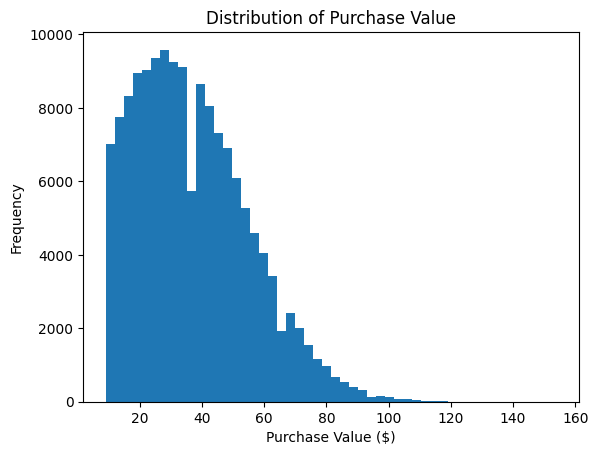

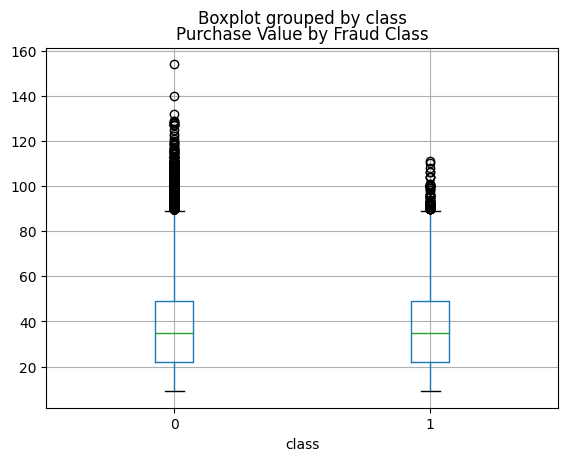

Class Distribution:
 class
0    136961
1     14151
Name: count, dtype: int64


In [9]:
# Univariate analysis
plt.hist(fraud_data['purchase_value'], bins=50)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value ($)')
plt.ylabel('Frequency')
plt.show()
plt.savefig('images/purchase_value_hist.png')
plt.close()

# Bivariate analysis
fraud_data.boxplot(column='purchase_value', by='class')
plt.title('Purchase Value by Fraud Class')
plt.show()
plt.savefig('images/purchase_value_by_class.png')
plt.close()

# Class imbalance
class_counts = fraud_data['class'].value_counts()
print("Class Distribution:\n", class_counts)

6. Merge Datasets for Geolocation Analysis

In [11]:
# Convert IP to integer with proper string conversion
def ip_to_int(ip):
    if pd.isna(ip):  # Handle NaN values
        return None
    # Convert to string and remove dots, then to int
    ip_str = str(ip).replace('.', '')
    return int(ip_str) if ip_str.isdigit() else None

# Apply the function to create integer representations
fraud_data['ip_int'] = fraud_data['ip_address'].apply(ip_to_int)
ip_country['lower_int'] = ip_country['lower_bound_ip_address'].apply(ip_to_int)
ip_country['upper_int'] = ip_country['upper_bound_ip_address'].apply(ip_to_int)

# Merge datasets
merged_data = pd.merge_asof(fraud_data.sort_values('ip_int'),
                           ip_country.sort_values('lower_int'),
                           left_on='ip_int',
                           right_on='lower_int',
                           direction='nearest')
merged_data = merged_data[['user_id', 'ip_int', 'country', 'class', 'purchase_time', 'signup_time']]
merged_data.to_csv('../data/processed/merged_data.csv', index=False)
print(f"Merged {len(merged_data)} rows with country data")

Merged 151112 rows with country data


7. Feature Engineering

In [12]:
# Time-based features
merged_data['hour_of_day'] = merged_data['purchase_time'].dt.hour
merged_data['day_of_week'] = merged_data['purchase_time'].dt.day_name()
merged_data['time_since_signup'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds() / 3600

# Transaction frequency
merged_data['transaction_freq'] = merged_data.groupby('user_id')['purchase_time'].transform('count')

# Save featured data
merged_data.to_csv('../data/processed/featured_data.csv', index=False)
print("Feature engineering completed. Saved to data/processed/featured_data.csv")

Feature engineering completed. Saved to data/processed/featured_data.csv


8. Data Transformation

In [13]:
# Analyze class imbalance
imbalance_ratio = class_counts[1] / class_counts[0]
print(f"Imbalance Ratio (Fraud/Non-Fraud): {imbalance_ratio:.2%}")

# Proposed strategy (to be implemented in Task 2)
# Note: SMOTE will be applied to training data only later
print("Proposed strategy: Use SMOTE for oversampling fraud cases to address 1:99 imbalance.")

Imbalance Ratio (Fraud/Non-Fraud): 10.33%
Proposed strategy: Use SMOTE for oversampling fraud cases to address 1:99 imbalance.
